In [1]:
#| default_exp tfsm/med

In [1]:
#| export 
import SimpleITK as sitk
import torch
import numpy as np 
import fastcore.all as fc

from pathlib import Path
from typing import Optional
from monai.transforms.spatial.array import Zoom

from voxdet.tfsm.standard import BaseT
from voxdet.tfsm.utils import corner_2_chwd, chwd_2_corner

from qct_utils.apps.lung_segment import LungLobeSeg
from qct_utils.schema.dim import Mask

/home/users/shubham.kumar/miniconda3/envs/qct_deep_clone/lib/python3.9/site-packages/scipy-1.9.1-py3.9-linux-x86_64.egg/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from voxdet.utils import vis, hu_to_lung_window
from voxdet.tfsm.standard import StandardT

import imageio
from IPython.display import Image as DisplayImage

In [4]:
%load_ext autoreload
%autoreload 2

## LungSegmentation using Deep learning

> read sitk image and store it in numpy format

In [5]:
## we will write our own version of `LungSegmentation` for now. 

In [6]:
import SimpleITK as sitk 

In [7]:
path = "../../resources/1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785.nii.gz"
img = sitk.ReadImage(path)
img.GetSpacing(), img.GetSize()

((0.5789999961853027, 0.5789999961853027, 3.0), (512, 512, 90))

In [8]:
fimg = sitk.GetArrayFromImage(img)
spacing = img.GetSpacing()[::-1]
fimg.shape, spacing

((90, 512, 512), (3.0, 0.5789999961853027, 0.5789999961853027))

In [12]:
margin: tuple = (2, 5, 5)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
#| export 
def get_bbox_from_mask(mask: np.ndarray, margin: Optional[tuple] = None):
    """mask is zyx and margin is zyx. output is zyxzyx format"""
    SZ, SY, SX = mask.shape  # zyx
    zz, yy, xx = np.where(mask.astype(bool))
    x1, x2 = np.min(xx) - margin[2], np.max(xx) + margin[2]
    y1, y2 = np.min(yy) - margin[1], np.max(yy) + margin[1]
    z1, z2 = np.min(zz) - margin[0], np.max(zz) + margin[0]
    return np.asarray([max(0, z1), max(0, y1), max(0, x1), min(SZ, z2), min(SY, y2), min(SX, x2)])

In [14]:
lung_seg = LungLobeSeg(checkpoint_path="/home/users/shubham.kumar/projects/qct_utils/src/qct_utils/apps/lung_segment/v2/resources/epoch=263_step=705_val_dice=0.95.ckpt", device=device)

In [15]:
lungmask , lobemask = lung_seg.predict_lung_lobe(sitk.GetArrayFromImage(img))
lungmask[lungmask >= 1] = 1
lungbox = get_bbox_from_mask(lungmask, margin)
lungbox

array([  6,  89,  53,  81, 391, 478])

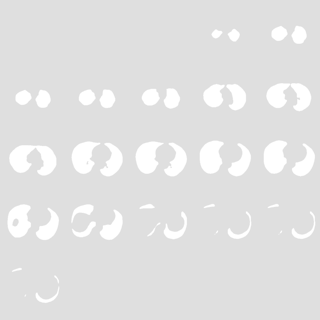

In [16]:
vis(lungmask*255, size=64)

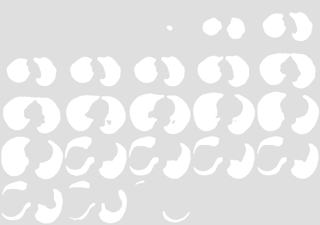

In [17]:
z1, y1, x1, z2, y2, x2 = lungbox
vis(lungmask[z1:z2, y1:y2, x1:x2]*255, size=64)

## If the LungMasks are already stored in Hub Dataset 

In [21]:
series_id = path.rsplit("/")[-1][:-7]
spacing = np.asarray(img.GetSpacing()[::-1])
series_id, spacing

('1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785',
 array([3.   , 0.579, 0.579]))

## CropLung

In [22]:
lungmask.shape, lungbox

((90, 512, 512), array([  6,  89,  53,  81, 391, 478]))

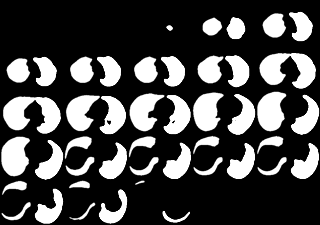

In [23]:
vis(lungmask[lungbox[0]: lungbox[3], lungbox[1]: lungbox[4], lungbox[2]: lungbox[5]]*255, size=64, window=False)

In [24]:
new_shape = np.round(lungmask.shape * spacing / np.asarray((1.0, 1.0, 1.0)))
# true_spacing = spacing * imgs.shape / new_shape
rf = new_shape / lungmask.shape
rf

array([3.      , 0.578125, 0.578125])

In [25]:
from monai.transforms.spatial.array import Zoom
maskre = Zoom(zoom=rf.tolist(), keep_size=False)(np.expand_dims(lungmask, 0))
maskre.shape

torch.Size([1, 270, 296, 296])

In [26]:
resample = rf.reshape(-1, 1).repeat(2, 1).T.reshape(-1)
resample

array([3.      , 0.578125, 0.578125, 3.      , 0.578125, 0.578125])

In [27]:
nbbox = lungbox*resample
nbbox

array([ 18.      ,  51.453125,  30.640625, 243.      , 226.046875,
       276.34375 ])

In [28]:
np.floor(15.2), np.ceil(15.2)

(15.0, 16.0)

In [29]:
nbbox[:3] = np.floor(nbbox[:3])
nbbox[3:] = np.ceil(nbbox[3:])
nbbox = nbbox.astype(int)
nbbox

array([ 18,  51,  30, 243, 227, 277])

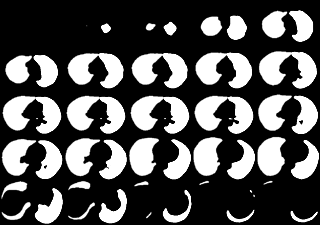

In [30]:
vis(maskre[0].numpy()[nbbox[0]: nbbox[3], nbbox[1]: nbbox[4], nbbox[2]: nbbox[5]]*255, size=64, window=False)

In [31]:
#| export 
def resize_factor(img_shape: tuple, spacing: tuple, new_spacing: tuple):
    """bbox=zyxzyx, img_shape=zyx spacing=zyx new_spacing=zyx"""
    new_shape = np.round(np.asarray(img_shape) * np.asarray(spacing)/ np.asarray(new_spacing))
    rf = new_shape / np.asarray(img_shape)
    return rf

In [32]:
#| export 
def resample_box(bbox, img_shape: tuple, spacing: tuple, new_spacing: tuple):
    """bbox=zyxzyx, img_shape=zyx spacing=zyx new_spacing=zyx"""
    nbbox = bbox.copy()
    rf = resize_factor(img_shape, spacing, new_spacing)
    resample = rf.reshape(-1, 1).repeat(2, 1).T.reshape(-1)
    nbbox = nbbox*resample
    return nbbox

In [33]:
resample_box(lungbox, lungmask.shape, spacing, (1.0, 1.0, 1.0))

array([ 18.      ,  51.453125,  30.640625, 243.      , 226.046875,
       276.34375 ])

In [34]:
bbox = np.asarray([ 45, 148,   8, 466, 413,  95])
spacing = np.asarray([0.64, 0.64, 3.])
img_shape = np.asarray([512, 512, 105])
nbbox = np.ceil(resample_box(bbox, img_shape, spacing, (1.0, 1.0, 1.0))).astype(int)
assert fc.all_equal(nbbox, np.asarray([ 29,  95,  24, 299, 265, 285])), "resample bbox is wrong"

In [35]:
#| export 
class AddLungCache(BaseT):
    def __init__(self, cache_dir: Optional[str]=None, device: str="cuda"):
        super().__init__()
        fc.store_attr()
        self.margin = (2, 5, 5)
        from qct_utils.apps.lung_segment import LungLobeSeg
        self.lsd = LungLobeSeg(checkpoint_path= "/home/users/shubham.kumar/projects/qct_utils/src/qct_utils/apps/lung_segment/v2/resources/epoch=263_step=705_val_dice=0.95.ckpt" ,device=self.device)
    __repr__ = fc.basic_repr(flds="cache_dir")
    
    def apply(self, img:dict):
        if "series_id" not in img.keys(): return img 
        if self.cache_dir is not None:
            lung_mask_path = Path(self.cache_dir)/(img["series_id"]+"_lung_mask.npy")
        else:
            img["lung_mask"] , _ = self.lsd.predict_lung_lobe(img["images"])
            return img 
        if not lung_mask_path.exists(): 
            img["lung_mask"] , _ = self.lsd.predict_lung_lobe(img["images"])
            np.save(lung_mask_path, img["lung_mask"])
            return img 
        img["lung_mask"] = np.load(lung_mask_path)
        return img 
    
    def reverse_apply(self, img: dict): return img

In [36]:
cache_dir = "/tmp/lung_seg"
fc.Path(cache_dir).mkdir(exist_ok=True, parents=True)

In [38]:
cache = AddLungCache(cache_dir=cache_dir, device = "cuda")

In [39]:
img ={}
img["series_id"] = path.rsplit(".nii.gz")[0].rsplit("/")[-1]
img["images"] = sitk.GetArrayFromImage(sitk.ReadImage(path))
print(img["images"].shape)
nimg = cache(img)
nimg["lung_mask"].shape

(90, 512, 512)


(90, 512, 512)

## Crop Lung 
- for this we need a image with bboxes on it. 
- based on some visualization, I have selected one bbox on the left and other on the right

In [40]:
img ={}
img["series_id"] = path.rsplit(".nii.gz")[0].rsplit("/")[-1]
img["images"] = sitk.GetArrayFromImage(sitk.ReadImage(path))
img["boxes"] = np.asarray([[38, 100, 200, 42, 200, 300], [60, 300, 300, 65, 400, 400]])

In [41]:
corner_2_chwd(img["boxes"]).astype(np.int16)

array([[ 40, 150, 250,   4, 100, 100],
       [ 62, 350, 350,   5, 100, 100]], dtype=int16)

In [42]:
from qct_utils.ctvis.draw import draw_bboxes_and_titles
from qct_utils.ctvis.viewer import plot_scans

In [43]:
tt = draw_bboxes_and_titles(img["images"], corner_2_chwd(img["boxes"]).astype(np.int16), titles=["b1", "b2"])

In [44]:
plot_scans([img["images"], tt], title_list=["scan", "scan_with_bbox"])

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…

> Lets crop the left lung now 

In [46]:
fimg = img["images"].copy()
lung_mask = lung_seg_dl(device)(fimg)

> lets crop the left lung mask 

In [47]:
left_lung_mask = lung_mask.copy()
left_lung_mask[left_lung_mask == 1] = 0
left_lung_mask[left_lung_mask == 2] = 1

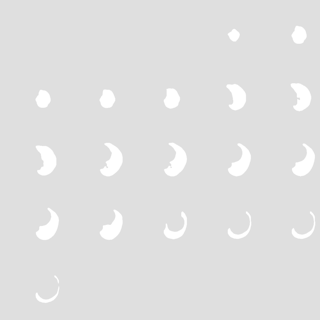

In [48]:
vis(left_lung_mask*255, size=64)

In [49]:
lung_box = get_bbox_from_mask(left_lung_mask, margin=(2, 5, 5))
lung_box

array([  6, 112, 270,  81, 391, 478])

> cut the image 

In [50]:
left_lung_crop = img["images"][lung_box[0]: lung_box[3], lung_box[1]: lung_box[4], lung_box[2]: lung_box[5]]
left_lung_crop.shape

(75, 279, 208)

> Bounding boxes 

In [51]:
from voxdet.tfsm.voxt import crop_bbox

In [52]:
img["boxes"]

array([[ 38, 100, 200,  42, 200, 300],
       [ 60, 300, 300,  65, 400, 400]])

In [53]:
img_size = (lung_box[3]-lung_box[0], lung_box[4]-lung_box[1], lung_box[5]-lung_box[2])
img_size

(75, 279, 208)

In [54]:
bboxes = crop_bbox(img["boxes"].copy(), lung_box, img_size)
bboxes

array([[ 32.,   0.,   0.,  36.,  88.,  30.],
       [ 54., 188.,  30.,  59., 279., 130.]])

In [58]:
tt = draw_bboxes_and_titles(left_lung_crop, corner_2_chwd(bboxes).astype(np.int16), titles=["b1", "b2"])

In [59]:
plot_scans([left_lung_crop, tt], title_list=["scan", "scan_with_bbox"])

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…

In [ ]:
#| export
class CropLung(BaseT):
    def __init__(self, 
                 margin: tuple=(2, 5, 5), 
                 device: str="cuda",
                 roi: Optional[str] = None,
                ):
        """ tuple in zyx format, roi could be "left" , right or None. Use AddLungCache if required."""
        super().__init__()
        fc.store_attr()
        from qct_utils.apps.lung_segment import LungLobeSeg
        self.lsd = LungLobeSeg(checkpoint_path="/home/users/shubham.kumar/projects/qct_utils/src/qct_utils/apps/lung_segment/v2/resources/epoch=263_step=705_val_dice=0.95.ckpt", device=self.device)
    
    __repr__ = fc.basic_repr(flds="margin")
        
    
    def apply(self, img:dict):
        from loguru import logger
        assert "images" in img.keys(), f"images are present in input {img.keys()}"
        series_id = img["series_id"] if isinstance(img["series_id"], str) else img["series_id"][0]
        fimg = img["images"].copy()
        img_shape = fimg.shape if len(fimg.shape) == 3 else fimg.shape[1:]
        nimg = {}
        if "lung_mask" in img.keys():
            nimg["lung_mask"] = img["lung_mask"]
        else:
            nimg["lung_mask"], _ = self.lsd.predict_lung_lobe(fimg)
            
        if self.roi == "left" : 
            left_lung_mask = nimg["lung_mask"].copy()
            left_lung_mask[left_lung_mask == 1] = 0
            left_lung_mask[left_lung_mask == 2] = 1
            nimg["lung_mask"] = left_lung_mask
            
        if self.roi == "right" : 
            right_lung_mask = nimg["lung_mask"].copy()
            right_lung_mask[right_lung_mask == 2] = 0
            nimg["lung_mask"] = right_lung_mask
            
        nimg["lung_box"] = get_bbox_from_mask(nimg["lung_mask"],self.margin)
        nimg["images"] = self.apply_image(fimg, nimg["lung_box"])
        
        if "boxes" in img : 
            nimg["boxes"] = self.apply_bbox(img["boxes"], nimg["lung_box"])
                     
        for i in img.keys(): 
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg
        
    def apply_image(self, img: np.asarray, b: np.asarray):
        out = img.copy()
        #bboxes are zyxzyx format and image is zyx
        out = out[b[0]: b[3], b[1]: b[4], b[2]: b[5]]
        return out
    
    def apply_bbox(self, bbox, lung_box):
        # bbox is zyxzyx where as lung box is zyxzyx
        from voxdet.tfsm.voxt import crop_bbox
        fb = lung_box  
        img_size = [fb[3]-fb[0], fb[4]-fb[1], fb[5]-fb[2]]
        out = crop_bbox(bbox.copy(), fb, img_size, keep_volume=0)
        return out
    
    def reverse_apply_bbox(self, bbox, lung_box):
        """lung mask is of original scan shope, bbox and lung_box can be or cannot be """
        out = bbox.copy()
        out = corner_2_chwd(bbox)
        out[:, 0] += lung_box[0]
        out[:, 1] += lung_box[1]
        out[:, 2] += lung_box[2]
        out = chwd_2_corner(out)
        return out
    
    def reverse_apply(self, img: dict):
        assert "lung_box" in img.keys(), f"lung_box not in {img.keys()}"
        nimg = {}
        nimg["boxes"] = self.reverse_apply_bbox(img["boxes"], img["lung_box"])
        for i in img.keys(): 
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg        

In [61]:
img = sitk.ReadImage("../../resources/1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785.nii.gz")
sh = {}
sh["images"] = sitk.GetArrayFromImage(img)
sh["series_id"] = "1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785"
sh["spacing"] = img.GetSpacing()[::-1]
sh["images"].shape

(90, 512, 512)

> Whole Lung Crop

In [64]:
clt = CropLung()

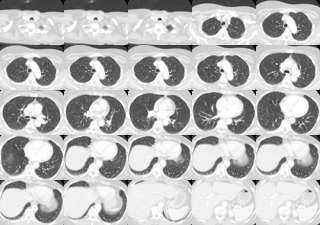

In [65]:
flc = clt(sh)
vis(flc["images"], 64, window=True)

> Left Crop

In [80]:
clt = CropLung(roi="left")

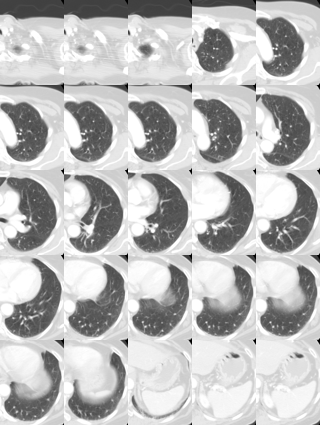

In [81]:
flc = clt(sh)
vis(flc["images"], 64, window=True)

In [83]:
clt = CropLung(roi="right")

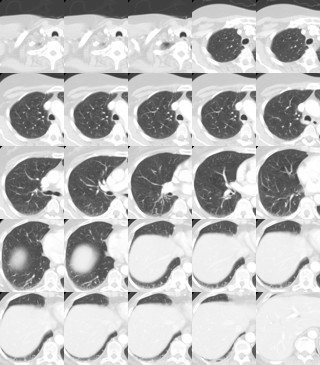

In [84]:
flc = clt(sh)
vis(flc["images"], 64, window=True)

In [65]:
# b = flc["boxes"][0]
# z1, y1, x1, z2, y2, x2 = b
# x1, y1, z1, x2, y2, z2 = list(map(int, (x1, y1, z1, x2, y2, z2)))
# x1, y1, z1, x2, y2, z2, flc["images"].shape

In [66]:
# kk = np.uint8(hu_to_lung_window(flc["images"].copy())*255)
# imageio.mimsave('sld_3.gif', [i for i in kk[z1-3:z2+3, y1-10:y2+10, x1-10:x2+10]])
# DisplayImage(data='sld_3.gif', width=180, height=180) 

## Windowing 

In [67]:
#| export 
class WindowT(BaseT):
    def __init__(self, wt: str=None, ww: int=None, wl: float=None):
        """window_type, window_width, window_level"""
        super().__init__()
        fc.store_attr()
        if all([i is None for i in [self.wt, self.ww, self.wl]]): raise ValueError("Everything cannot be none")    
        if self.wt is None: 
            assert all([i is not None for i in [self.ww, self.wl]]), ValueError("ww and wl cannot be None when wt is none")
        
        self.windows = self._default_windows()
        
        if (self.wt is not None) & (self.wt in list(self.windows)): 
                level = self.windows[self.wt]
                self.ww, self.wl= level
        
        if (self.wt is not None) & (self.wt not in list(self.windows)):
            assert all([i is not None for i in [self.ww, self.wl]]), ValueError(f"wt:{self.wt} is not available in {list(self.windows)} and ww, wl is None")
        
        self.low = self.wl - self.ww/2
        self.high = self.wl + self.ww/2
    
    __repr__ = fc.basic_repr(flds="wt, ww, wl")
    
    def _default_windows(self):
        k = {}
        k["lung"] = (1600, -600)
        k["soft_tissue"] = (350, 40)
        return k
    
    def apply(self, img: dict):
        assert "images" in img.keys(), "images key is not present"
        fimg = img["images"]
        nimg = {}
        nimg["images"] = self.apply_image(fimg)
        for i in img.keys(): 
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg 
    
    def apply_image(self, img):
        out = img.copy()
        out = (out-self.low)/(self.high-self.low)
        out = np.clip(out, 0, 1)
        return out.astype(np.float32)
    
    def reverse_apply(self, img): return img 

In [68]:
fc.test_fail(WindowT, kwargs=dict(wt=None, ww=None, wl=None))
fc.test_fail(WindowT, kwargs=dict(wt="lungt", ww=None, wl=None))

In [69]:
x={}
x["images"] = np.asarray([[200, -1400]])
fw = WindowT(wt="lung")
y = fw(x)
assert fc.all_equal(y["images"],  np.asarray([[1., 0]])), "lung windowing is wrong"

In [70]:
wst = WindowT("lung")

In [71]:
fw = wst(sh)

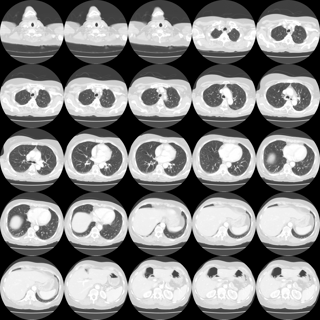

In [72]:
vis(fw["images"]*255, 64, window=False)

## Resample Scan and bbox 

In [88]:
import SimpleITK as sitk 
img = sitk.ReadImage("../../resources/1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785.nii.gz")
img.GetSpacing(), img.GetSize()

((0.5789999961853027, 0.5789999961853027, 3.0), (512, 512, 90))

In [89]:
fimg = sitk.GetArrayFromImage(img)
spacing = img.GetSpacing()[::-1]
fimg.shape, spacing

((90, 512, 512), (3.0, 0.5789999961853027, 0.5789999961853027))

In [90]:
exp = {"images": fimg, "boxes": np.asarray([[10., 10., 10., 20., 20., 20.]]), \
       "series_id": "1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785",\
       "spacing": spacing}

In [91]:
rf = resize_factor(fimg.shape, spacing, (1., 1., 1.))
print(rf)
rimg = Zoom(zoom=rf.tolist(), keep_size=False)(fimg[None])[0]
rimg.shape

[3.       0.578125 0.578125]


torch.Size([270, 296, 296])

In [92]:
#| export
class Resample(BaseT):
    def __init__(self, req_spacing: tuple=(1.0, 1.0, 1.0)):
        """req_spacing is in zyx format"""
        fc.store_attr()
        super().__init__()
    __repr__ = fc.basic_repr(flds="req_spacing")
    
    def apply(self, img: dict):
        assert all([i in list(img.keys()) for i in ["images", "spacing"]])
        fimg, spacing = img["images"], img["spacing"]
        img_shape = img["images"].shape if len(img["images"].shape) == 3 else img["images"].shape[1:]
        nimg = {}
        nimg["images"] = self.apply_image(fimg, spacing)
        if "boxes" in img.keys(): nimg["boxes"] = self.apply_bbox(img["boxes"], img_shape, spacing)
        for i in img.keys(): 
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg
    
    def apply_image(self, img, spacing):
        out = img.copy()
        rf = resize_factor(out.shape, spacing, self.req_spacing)
        rimg = Zoom(zoom=rf.tolist(), keep_size=False)(out[None])[0].numpy()
        return rimg.astype(np.float64)
        
    def apply_bbox(self, bbox, img_shape, spacing):
        out = bbox.copy().astype(np.float64)
        return resample_box(out, img_shape, spacing, self.req_spacing)
    
    def reverse_apply(self, img: dict):
        assert "boxes" in img.keys()
        out = img["boxes"].copy()
        img_shape = img["images"].shape if len(img["images"].shape) == 3 else img["images"].shape[1:]
        img["boxes"] = resample_box(out, img_shape, self.req_spacing, img["spacing"])
        return img

In [93]:
x = Resample()
x

__main__.Resample(req_spacing=(1.0, 1.0, 1.0))

In [94]:
out = x(exp)

In [95]:
exp["images"].shape, out["images"].shape

((90, 512, 512), (270, 296, 296))

In [96]:
exp["boxes"], out["boxes"]

(array([[10., 10., 10., 20., 20., 20.]]),
 array([[30.     ,  5.78125,  5.78125, 60.     , 11.5625 , 11.5625 ]]))

In [97]:
x.reverse_apply(out)["boxes"]

array([[10.        ,  9.98046875,  9.98046875, 20.        , 19.9609375 ,
        19.9609375 ]])

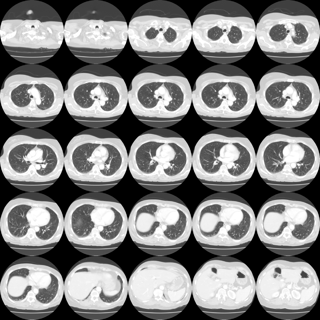

In [98]:
vis(out["images"], 64)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()